#__02-620 HW4 Programming - Image classification using Pytorch__

In this last homework, we will learn basic deep learning. Deep learning is a fast moving research area. There is ongoing research on why it works so well, but so far the theory of deep learning is still building in progress. Due to this nature of the field, hands-on experience is the most important in deep learning.

We will use Pytorch, one of the popular deep learning frameworks. If you are unfamiliar with the Pytorch, please watch the recitation video and look at the recitation material, where we covered basic understanding of Pytorch.

Because our course is an introductory machine learning course, we covered broad topics in machine learning and thus we can't go very deep into deep learning. So we will go through only the basics of deep learning. Throughout the homework, we hope you'll get familiar with deep learning and Pytorch framework.

Referenced 16-720 and 16-824, great courses in CMU

In [1]:
#Feel free to import any required library you need.
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import pandas as pd
torch.manual_seed(0) #For reproducibility

#__General Task description__

In this assignment, our task is to build a workflow of classifying the objects using deep learning models. The dataset we are interested in is CIFAR10(https://www.cs.toronto.edu/~kriz/cifar.html). This dataset includes 60,000 32x32 color images in 10 clases. It has 50,000 training samples and 10,000 test samples. You can download the dataset using torchvision.datasets.CIFAR10()

__TODOs__
1. Change path to your desired path!!!
2. Once you download your data, you can change it to False

In [2]:
your_path=r'./data'
download=False
#Download the dataset and transform it to tensor
transform=torchvision.transforms.Compose([torchvision.transforms.Resize((256)),torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root=your_path, train=True,download=download,transform=transform)
testset = torchvision.datasets.CIFAR10(root=your_path, train=False, download=download,transform=transform)

#__Task 1 Build your own DataLoader(10 Points)__

As we covered in the recitation, Pytorch uses the DataLoader class to bring datapoints to the neural network. You can do any preprocessing in this step.

Take a look at https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

There can be possibility that you don't have enough dataset. In this case, we can populate the dataset using data augmentation. For example, in Computer Vision, one way to augment your data is adding rotated images.

BE CAREFUL: In Pytorch, one of the argument in the DataLoader is indicating train or test. This is very important argument because you do data augmentation with training samples, but not with test samples. You should consider this when you implement DataLoader.

Tip:
1. It is very important to understand what is your data and how they are organized. Observe how folder and files strutured in the downloaded CIFAR10. See the annotation files, open the images, try to see if there is any pattern in file name, etc.
2. For data augmentation, feel free to use methods in torchvision.transforms

__TODOs__
1. Form your own DataLoader
2. In the __getitem__, add your own data augmentation.
3. You should have an variable that controls size of the image. For this assignment, use size of 256: that is, image should be (256, 256, 3). Please be mind that when you load this image to the Tensor, it might be changed to (3, 256, 256)

In [3]:
#This is copied from the Pytorch document. Feel free to utilize it, or build entirely new one
from torch.utils.data import Dataset
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform 
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Now you should be able to bring and use your Dataloader

In [4]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 3, 256, 256])
Labels batch shape: torch.Size([64])


#__Task 2 Build Neural Network(5 Points)__

If you look at some of the deep learning papers, they provide their model architecture, which is how they organized their neural network. Through this task, you should be able to rebuild the neural network given model architecture.
The model we are interested in is AlexNet(https://arxiv.org/abs/1404.5997). For simplicity, we are going to implement a slightly simplified version.


This is the model you should rebuild:

AlexNet(

  (features): Sequential(
  
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace))
  
  (classifier): Sequential(
  
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace)
    (4): Conv2d(256, 20, kernel_size=(1, 1), stride=(1, 1)))
)


__TODO: Implement the model architcture__

In [36]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        
        #TODO: Define Features
        self.features=nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
        )    
        
        
        #TODO: Define Classifiers
        self.classifier=nn.Sequential(
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1)),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 10, kernel_size=(1, 1), stride=(1, 1))
        )
            

        
        #We will give this initialization for you
        for neuron in self.features:
            if isinstance(neuron,nn.Conv2d):
                nn.init.xavier_uniform_(neuron.weight)
        
        
    def forward(self, x):
        #TODO: Define forward pass
        
        x=self.features(x)
        x=self.classifier(x)
        return x
model = AlexNet()  
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 10, kernel_

#__Task 3 Build deep learning pipeline(20 Points)__

You have Dataset, DataLoader, and your model. It's time to make a pipeline with ingredients. In the recitation, we covered that before we build a training loop, we need to define loss and optimizer. Due to the limited time, we will provide you with loss and optimizer. Use the given parameters.

In [34]:
#Do not change this cell

num_iter=20
loss_fn=nn.BCELoss()
optimizer=torch.torch.optim.SGD(model.parameters(),lr=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min')

Now, build a deep learning pipeline. 

__TODOs: Finish the pipeline. Bring your DataLoader and the model here. Organize the train loop and test loop, and then train and test your model. At the end of the pipeline, your pipeline should be able to provide graphs of training accuracy, test accuracy and training loss, and report final test accuracy. If you implement it well, your test accuracy should be around 65%.__

__IMPORTANT: After you get predictions from your model, please add below codes before you put the prediction into loss function. Remember below lines should be added in both training loop and test loop!__

        (assume you used pred=model(X))
        '''
        final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
        pred=final_layer(pred)
        pred=torch.reshape(pred,(-1,10))#(-1,10)
        pred=F.sigmoid(pred)
        '''
        Then loss(pred,y) and goes on

In [37]:
def train_loop(dataloader, model, loss_fn, optimizer,epoch_index=0):
    size = len(dataloader.dataset)
    running_loss=0.
    last_loss=0.
    correct = 0
    total = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device),y.to(device)
        y=F.one_hot(y,num_classes=10).type(torch.float)
        # Compute prediction and loss
        pred = model(X)
        final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
        pred=final_layer(pred)
        pred=torch.reshape(pred,(-1,10))#(-1,10)
        pred=F.sigmoid(pred)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch % 100 == 99:    # print every 100 mini-batches
            last_loss=running_loss/100
            print(f'[{epoch_index+1},{batch+1:5d}] loss: {running_loss/100:.3f}')
            running_loss = 0.0

        #calculate accuracy
        total += y.size(0)
        correct += (pred.argmax(1) == y.argmax(1)).sum().item()

    train_acc = 100.0 * correct / total
    return last_loss, train_acc


def test_loop(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            y=F.one_hot(y,num_classes=10).type(torch.float)
            X, y = X.to(device),y.to(device)
            pred = model(X)
            final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
            pred=final_layer(pred)
            pred=torch.reshape(pred,(-1,10))#(-1,10)
            pred=F.sigmoid(pred)
            test_loss += loss_fn(pred, y).item()

            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct




train_loss=[]
test_loss=[]
train_accuracy=[]
test_accuracy=[]
epochs = num_iter
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_fn=nn.BCELoss()
    optimizer=torch.torch.optim.SGD(model.parameters(),lr=0.1)
    trainLoss, trainAcc = train_loop(trainloader, model, loss_fn, optimizer,t)
    testLoss, testAcc = test_loop(testloader, model, loss_fn)
    train_loss.append(trainLoss)
    test_loss.append(testLoss)
    train_accuracy.append(trainAcc)
    test_accuracy.append(testAcc)

    #update learning rate
    scheduler.step(testLoss)
print("Done!")

Epoch 1
-------------------------------
[1,  100] loss: 0.578
[1,  200] loss: 0.334
[1,  300] loss: 0.327
[1,  400] loss: 0.326
[1,  500] loss: 0.325
[1,  600] loss: 0.325
[1,  700] loss: 0.325
Test Error: 
 Accuracy: 13.4%, Avg loss: 0.323921 

Epoch 2
-------------------------------
[2,  100] loss: 0.323
[2,  200] loss: 0.320
[2,  300] loss: 0.314
[2,  400] loss: 0.307
[2,  500] loss: 0.306
[2,  600] loss: 0.304
[2,  700] loss: 0.301
Test Error: 
 Accuracy: 22.1%, Avg loss: 0.302252 

Epoch 3
-------------------------------
[3,  100] loss: 0.299
[3,  200] loss: 0.297
[3,  300] loss: 0.296
[3,  400] loss: 0.295
[3,  500] loss: 0.292
[3,  600] loss: 0.293
[3,  700] loss: 0.291
Test Error: 
 Accuracy: 26.7%, Avg loss: 0.287615 

Epoch 4
-------------------------------
[4,  100] loss: 0.287
[4,  200] loss: 0.288
[4,  300] loss: 0.286
[4,  400] loss: 0.285
[4,  500] loss: 0.284
[4,  600] loss: 0.284
[4,  700] loss: 0.283
Test Error: 
 Accuracy: 27.5%, Avg loss: 0.285173 

Epoch 5
--------

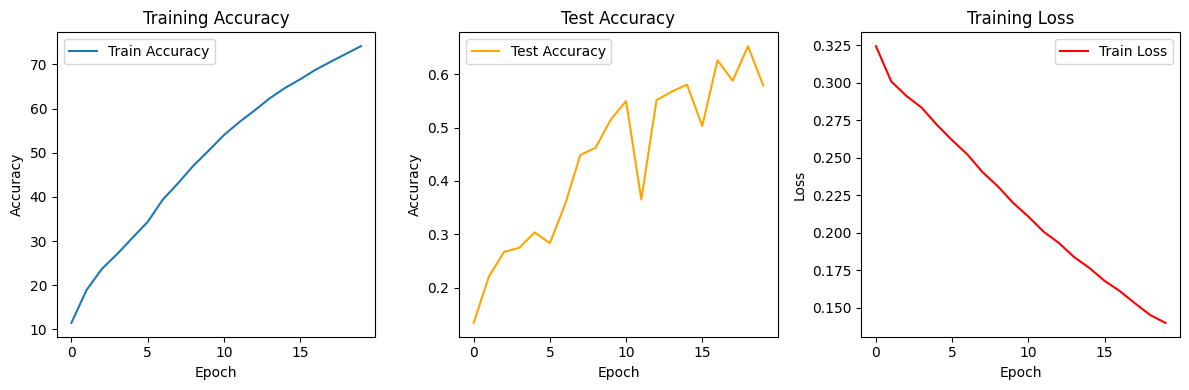

In [38]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_accuracy, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_loss, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.tight_layout()
plt.show()

#__Task 4 Weight transfer(Transfer learning)(5 Points)__

There can be two possible scenarios when you are given neural network architcture: One is build everything entirely from the scratch, as you implemented above, and the other is using the pretrained model. The former is preferred when there is no pretrained model or you are training with novel(or unpopular) dataset. The latter is generally more preferred, especially if you are working in computer vision or natural langauge processing related area, because most of the pretrained neural network works very well and their pretrained dataset is very large scale such that starting from raw training might consume great amount of time. For the latter case, it's just one line of code:

In [ ]:
#model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True) #DO NOT USE THIS CODE IN THIS ASSIGNMENT

In this task, we will slightly tweak: You will not use the above code to bring a pretrained model. Instead, you will transfer the weights of the pretrained model to the model you built above. Knowing this will help you later when you want to build your own model but basic flow comes from previous existing models.

One thing you should know, and should remember for your future is that Pytorch stores trained weights as a dictionary data structure, the key and value, and their name of the key has a pattern such that you can easily load your desired key and corresponding weights.


If your implementation is correct, your final accuracy should be around 80%


__TODOs: Implement below weight transfer function. Then train and test your pretrained model.Provide graphs of training accuracy, test accuracy and training loss. Report final accuracy__

In [24]:
from torchvision._internally_replaced_utils import load_state_dict_from_url

def Load_Alexnet_Weight_Transferred(pretrained=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model_urls = {
        'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
    }    
    
    model = AlexNet(**kwargs)
    model.to(device)
    # Initialize weights correctly based on whether it is pretrained or not
    if pretrained:
        # Load pretrained weights
        state_dict = load_state_dict_from_url(model_urls['alexnet'])
        
        # Remove classifier layers from the state_dict to handle dimension mismatch
        state_dict = {k: v for k, v in state_dict.items() if 'classifier' not in k}

        #exam the parameters in state_dict and model
        for param_tensor in model.state_dict():
            print(param_tensor, "\t", model.state_dict()[param_tensor].size())
        print('---------------------------')
        for param_tensor in state_dict:
            print(param_tensor, "\t", state_dict[param_tensor].size())


        model.load_state_dict(state_dict, strict=False)
        
    return model

model_pretrained = Load_Alexnet_Weight_Transferred(pretrained=True)
model_pretrained.to(device)

features.0.weight 	 torch.Size([64, 3, 11, 11])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 5, 5])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.0.weight 	 torch.Size([256, 256, 3, 3])
classifier.0.bias 	 torch.Size([256])
classifier.2.weight 	 torch.Size([256, 256, 1, 1])
classifier.2.bias 	 torch.Size([256])
classifier.4.weight 	 torch.Size([10, 256, 1, 1])
classifier.4.bias 	 torch.Size([10])
---------------------------
features.0.weight 	 torch.Size([64, 3, 11, 11])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 5, 5])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size(

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(256, 10, kernel_

In [39]:
#Use your previous training and test loops, but don't forget to use above model
train_loss=[]
test_loss=[]
train_accuracy=[]
test_accuracy=[]
epochs = num_iter
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_fn=nn.BCELoss()
    optimizer=torch.torch.optim.SGD(model_pretrained.parameters(),lr=0.1)
    trainLoss, trainAcc = train_loop(trainloader, model_pretrained, loss_fn, optimizer,t)
    testLoss, testAcc = test_loop(testloader, model_pretrained, loss_fn)
    train_loss.append(trainLoss)
    test_loss.append(testLoss)
    train_accuracy.append(trainAcc)
    test_accuracy.append(testAcc)

    #update learning rate
    scheduler.step(testLoss)
print("Done!")



Epoch 1
-------------------------------
[1,  100] loss: 0.147
[1,  200] loss: 0.148
[1,  300] loss: 0.143
[1,  400] loss: 0.144
[1,  500] loss: 0.140
[1,  600] loss: 0.137
[1,  700] loss: 0.134
Test Error: 
 Accuracy: 72.1%, Avg loss: 0.146265 

Epoch 2
-------------------------------
[2,  100] loss: 0.124
[2,  200] loss: 0.123
[2,  300] loss: 0.122
[2,  400] loss: 0.126
[2,  500] loss: 0.122
[2,  600] loss: 0.123
[2,  700] loss: 0.118
Test Error: 
 Accuracy: 70.9%, Avg loss: 0.149626 

Epoch 3
-------------------------------
[3,  100] loss: 0.111
[3,  200] loss: 0.110
[3,  300] loss: 0.110
[3,  400] loss: 0.113
[3,  500] loss: 0.111
[3,  600] loss: 0.109
[3,  700] loss: 0.104
Test Error: 
 Accuracy: 72.9%, Avg loss: 0.144466 

Epoch 4
-------------------------------
[4,  100] loss: 0.098
[4,  200] loss: 0.099
[4,  300] loss: 0.097
[4,  400] loss: 0.100
[4,  500] loss: 0.098
[4,  600] loss: 0.097
[4,  700] loss: 0.102
Test Error: 
 Accuracy: 67.9%, Avg loss: 0.173025 

Epoch 5
--------

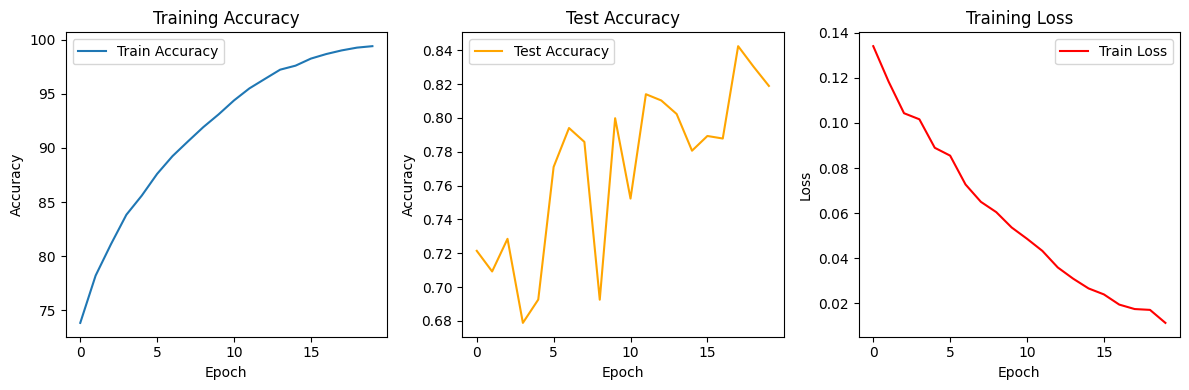

In [40]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_accuracy, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_loss, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.tight_layout()
plt.show()

#__Task 5 Evaluate your model(10 Points)__

You have a full loop of both train and test. Let's see how good your model is. In the lecture, we learned precision, recall. In addition to these metrics, one way to visualize our model performance is to show a heatmap of classification result. You need to build a (# classes)x(# classes) matrix. Then, for each sample in the test set with a true label ith class, we can get jth class through your model. Then we add a value to matrix[i][j], then we normalize the matrix. By doing so, we can visually show our performance. Remember that in CIFAR10, we have 10 classes. 

__TODOs__
1. Visualize the heatmap, and report which class showed most accurate, and which 'task' showed most mistakes, i.e, predicted j when the true label is i.
2. Provide 3 cases of failed prediction with most mistakes 'task'. So you should show a total of 6 images here. Briefly write why you think the model can't predict well.

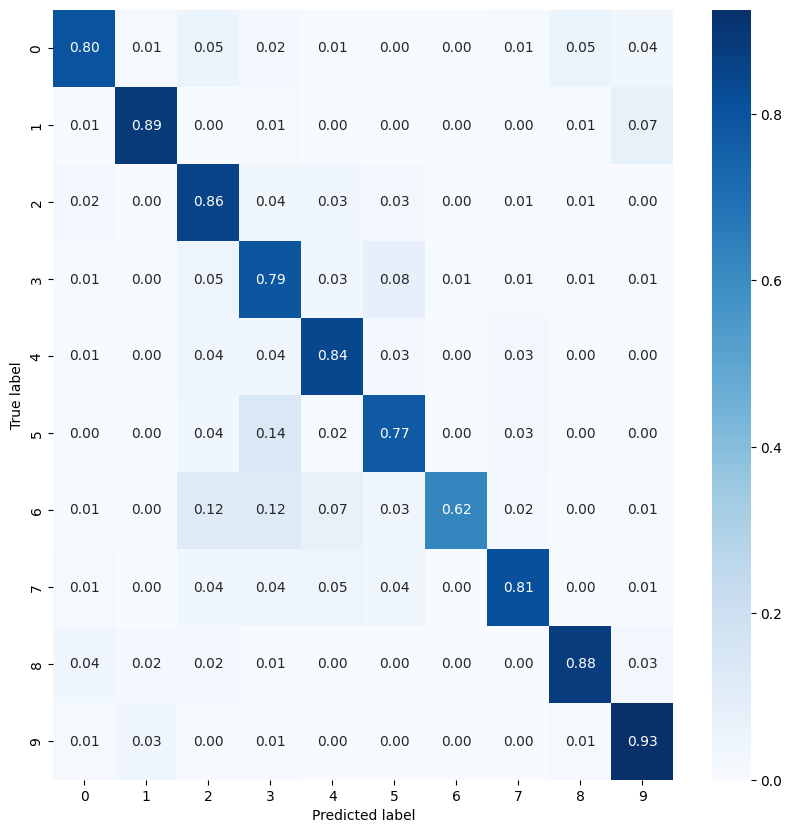

In [41]:
#Your code here
#model is pretrained
#show a heatmap of classification result

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

predictions=[]
labels=[]
with torch.no_grad():
    for X, y in testloader:
        y=F.one_hot(y,num_classes=10).type(torch.float)
        X, y = X.to(device),y.to(device)
        pred = model_pretrained(X)
        final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
        pred=final_layer(pred)
        pred=torch.reshape(pred,(-1,10))#(-1,10)
        pred=F.sigmoid(pred)
        pred=pred.argmax(1)
        predictions.append(pred)
        labels.append(y.argmax(1))

predictions=torch.cat(predictions)
labels=torch.cat(labels)
cm=confusion_matrix(labels.cpu(),predictions.cpu())
cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='.2f',cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



The class with the highest accuracy is truck
The class with the lowest accuracy is frog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The predicted class is deer
The true class is dog


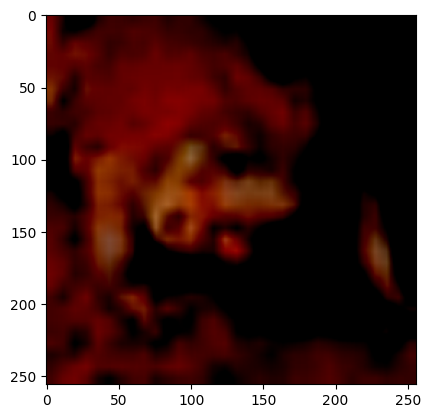

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The predicted class is cat
The true class is frog


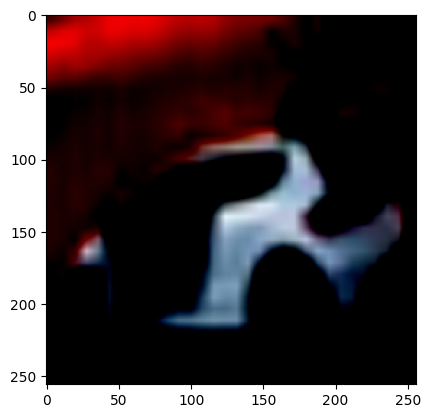

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The predicted class is truck
The true class is car


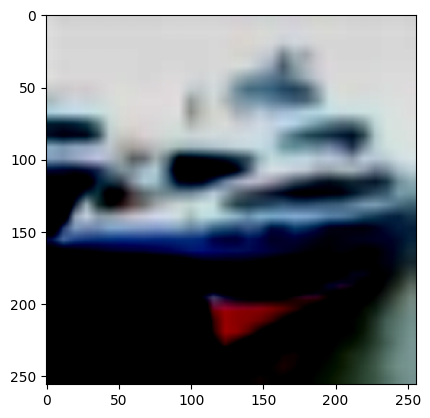

In [46]:
#report the class with the highest accuracy and the class with the lowest accuracy
accuracies=cm.diagonal()
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('The class with the highest accuracy is',classes[np.argmax(accuracies)])
print('The class with the lowest accuracy is',classes[np.argmin(accuracies)])


#Provide 3 cases of failed prediction with most mistakes 'task'.
failed_cases = [(i,j) for i,j in zip(predictions,labels) if i!=j]
for i in failed_cases[:3]:
    print('The predicted class is',classes[i[0]])
    print('The true class is',classes[i[1]])
    plt.imshow(testset[i[1]][0].permute(1,2,0))
    plt.show()



CIFAR-10 has a different set of classes than ImageNet. AlexNet was trained on ImageNet, which has 1000 classes, while CIFAR-10 has only 10 classes. The models trained on ImageNet may have learned features that are specific to the classes present in ImageNet, and may not be suitable for CIFAR-10.
The CIFAR-10 dataset is more challenging than ImageNet. The images in CIFAR-10 are smaller and have lower resolution compared to ImageNet, making it harder for the model to capture the relevant features. Additionally, the classes in CIFAR-10 are more similar to each other, making it harder for the model to distinguish between them.

#__Task 6 Create your own model(10 Points OR 10 Points + 10 Bonus Points)__

You have two options, and this task is open ended. 

Make your own model. Name the model class with your name(e.g. YoungJeNet). Briefly describe how you organized your model architecture and pipeline, and why you proposed such architecture (feel free to take inspiration from common architectures, and please reference any tutorials/guides that you use). Feel free to use your designed DataLoader and feel free to weight shift from any different model. Also feel free to use your training and test loop.
With your defined model, run your pipeline on a new dataset and provide graphs of training accuracy and training loss, and report final accuracy.

Do NOT just bring pretrained model: Like model=some_kind_of_pretrained_model(pretrain=True)

For your new dataset, choose one of the following options:
1. (10 Points) One of the following standard datasets: CIFAR10, PASCAL VOC, CALTECH256, or ImageNet2012.

2. (10 Points + 10 Bonus Points) Find a dataset of your interest in biology. We are giving bonus points here because you need to describe further about your dataset and may need to work more with Dataloader.

Please be mind that if you choose 2, this should not be part of your project.

Your score will be determined based on 1. Description of dataset 2. Clearly stated idea and correctly implemented the idea. 3. Not too low accuracy. Please be aware that accuracy is not the only criterion here.

In [ ]:
#Your Model

(Option) For your career, we encourage you to upload your work on Github. Github is a repository for programmers. This repo can be useful to your future career, especially if you aim to work in a computational job: provide your Github link to recruiter/research POI. By doing so, you can show your recruiter/research POI that you have fundamental ability to work with deep learning and being able to code Pytorch.

Congratulations! Now you understand the basic flow of deep learning workflow. CMU provides a variety of deep learning courses, so we recommend taking any of them if you are interested or strengthen your knowledge and skills in deep learning. If you want to learn general deep learning, consider 11-685 Introduction to Deep learning. Be careful that this course is very hectic. LTI and RI offer domain specific deep learning courses(such as Natural Language Processing, Visual Learning and Recognition). If you want to know deep learning theory, consider 10-707. Please be aware that what we've covered in this assignment is very basic: this is going to be assignment 0 for other deep learning courses. However, we believe that this assignment will work as a immigration assignment to deep learning.